## Import Libraries

#### Import Necessary Libraries.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from lightgbm import LGBMClassifier
import lightgbm as lgb
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV, KFold
import xgboost as xgb
from lightgbm import LGBMClassifier
import warnings
from scipy.stats import skew

warnings.filterwarnings('ignore')

## Exploratory Data Analysis

#### Read CSV Data Files

In [39]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
submission = pd.read_csv('sample_submission.csv')

#### Show First Rows

In [40]:
pd.set_option('display.max_columns', None)
train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


#### Drop `id` Column then Confirm DataFrame dimensions

In [41]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

print(f"df Train shape {train.shape}")
print(f"df Test shape {test.shape}")

df Train shape (593994, 12)
df Test shape (254569, 11)


#### Check For Null And Duplicate Values

In [42]:
print("Number of null value in Train DataFrames : ",train.isna().sum().sum())
print("Number of null value in Test DataFrames : ",test.isna().sum().sum())
print("Number of Duplicated Row in Train DataFrames : ", train.duplicated().sum())
print("Number of Duplicated Row in Test DataFrames : ", test.duplicated().sum())

Number of null value in Train DataFrames :  0
Number of null value in Test DataFrames :  0
Number of Duplicated Row in Train DataFrames :  0
Number of Duplicated Row in Test DataFrames :  0


#### Show Numerical and Categorical Columns

In [43]:
num_cols = train.select_dtypes(exclude= 'object').columns
cat_cols = train.select_dtypes(include= 'object').columns

print('Numerical columns :', ', '.join(num_cols))
print("Number of numerical columns:" ,len(num_cols))
print("")
print('Categorical columns :', ', '.join(cat_cols))
print("Number of categorical columns:" ,len(cat_cols))

Numerical columns : annual_income, debt_to_income_ratio, credit_score, loan_amount, interest_rate, loan_paid_back
Number of numerical columns: 6

Categorical columns : gender, marital_status, education_level, employment_status, loan_purpose, grade_subgrade
Number of categorical columns: 6


## Analysis of Data:

#### Numerical Features Analyse

In [44]:
train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,593994.0,48212.202976,26711.942078,6002.430,27934.400,46557.680,60981.320,393381.740
debt_to_income_ratio,593994.0,0.120696,0.068573,0.011,0.072,0.096,0.156,0.627
credit_score,593994.0,680.916009,55.424956,395.000,646.000,682.000,719.000,849.000
loan_amount,593994.0,15020.297629,6926.530568,500.090,10279.620,15000.220,18858.580,48959.950
interest_rate,593994.0,12.356345,2.008959,3.200,10.990,12.370,13.680,20.990
loan_paid_back,593994.0,0.798820,0.400883,0.000,1.000,1.000,1.000,1.000


#### Numerical Features Data Type

In [45]:
type(num_cols)

pandas.core.indexes.base.Index

#### Numerical Features Correlation

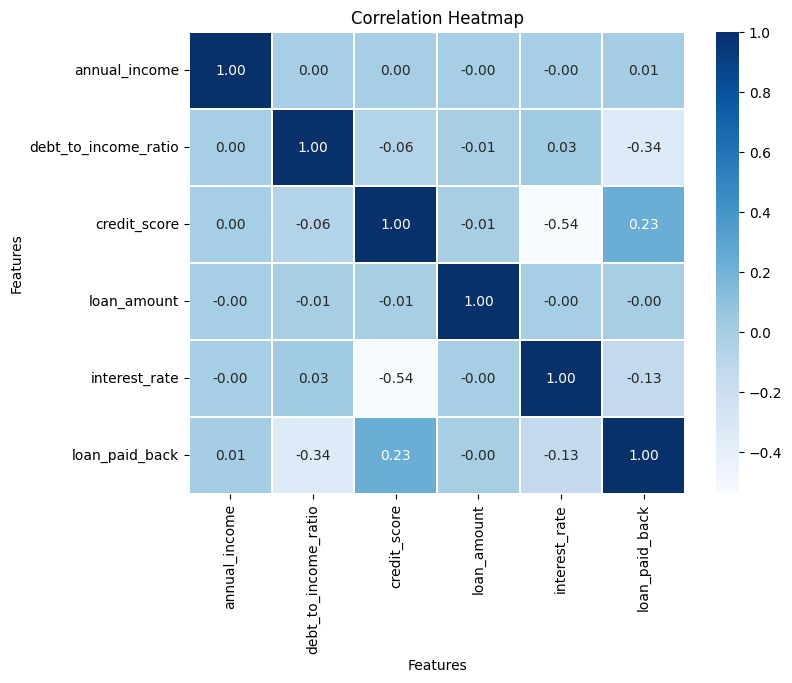

In [46]:
plt.figure(figsize=(8, 6))
correlation_matrix = train[num_cols ].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=0.1, cmap="Blues")
plt.title('Correlation Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

#### Drop Loan Paid Back Column

In [47]:
num_cols=num_cols.drop('loan_paid_back')

#### Numerical Features Distributions and Outliers

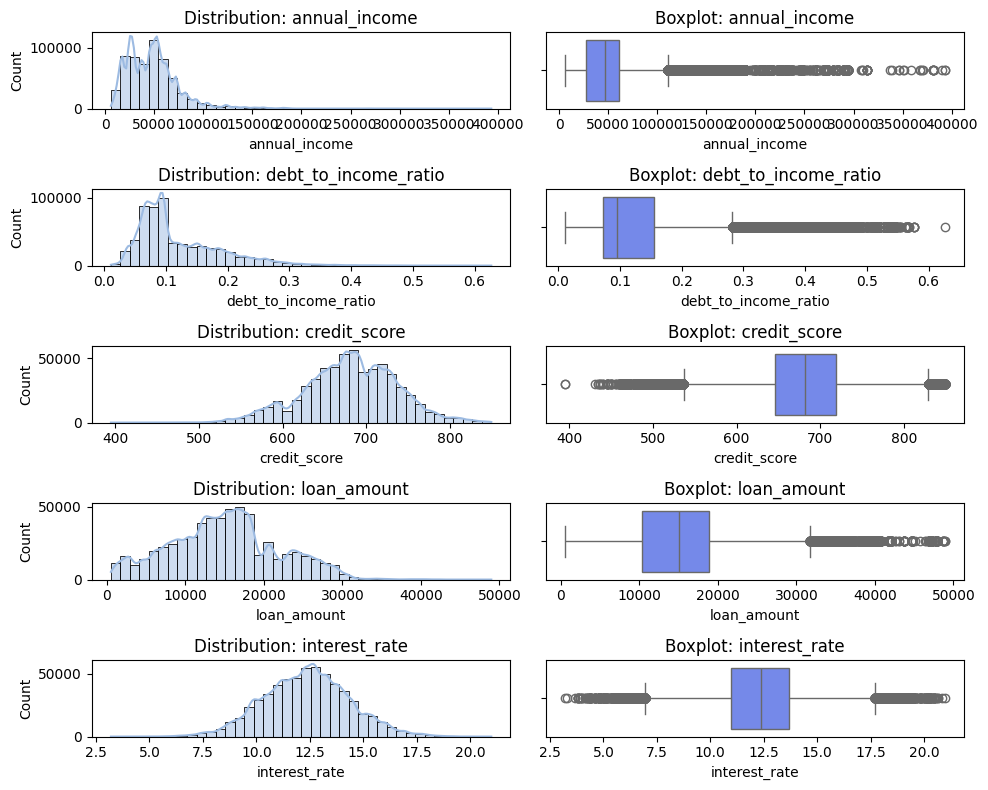

In [48]:
plt.figure(figsize=(10, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 2, 2*i - 1)
    sns.histplot(train[col], kde=True, bins=40, color="#9dbbe2")
    plt.title(f'Distribution: {col}')

    plt.subplot(len(num_cols), 2, 2*i)
    sns.boxplot(x=train[col], color="#627cfc")
    plt.title(f'Boxplot: {col}')

plt.tight_layout()
plt.show()

#### Numerical Features Skewness

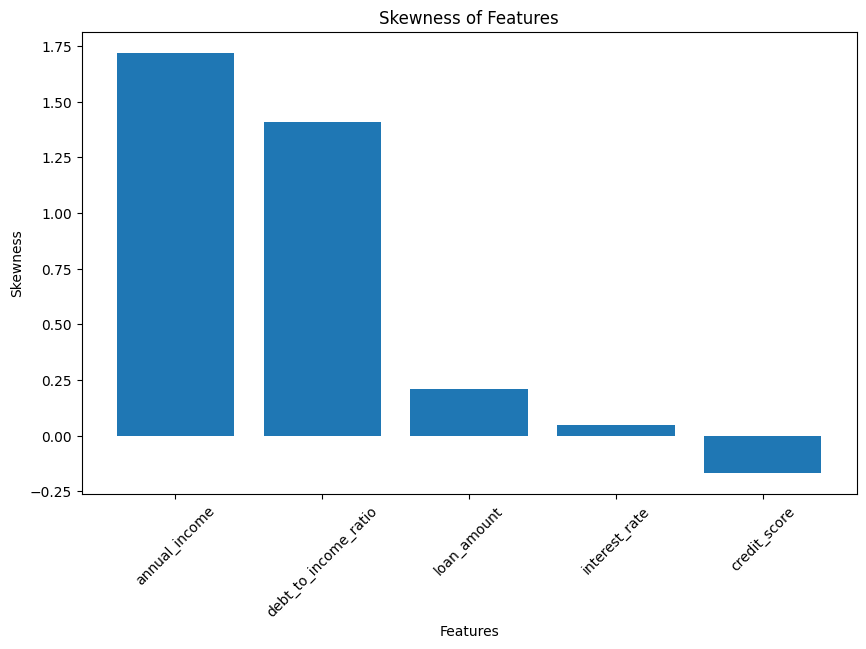

annual_income           1.719509
debt_to_income_ratio    1.406680
loan_amount             0.207360
interest_rate           0.049945
credit_score           -0.166993
dtype: float64


In [49]:
skew_values = train[num_cols].apply(lambda s: skew(s.dropna(), bias=False))
sorted_skew_values = skew_values.sort_values(ascending=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(sorted_skew_values.index, sorted_skew_values.values)
plt.title('Skewness of Features')
plt.xlabel('Features')
plt.ylabel('Skewness')
plt.xticks(rotation=45)
plt.show()
print(sorted_skew_values)

In [52]:
right_skewed_cols = skew_values[skew_values > 1].index.tolist()

print("Highly skewed columns:", ', '.join(right_skewed_cols))



for col in right_skewed_cols:
    train[col] = np.log1p(train[col])
    test[col]  = np.log1p(test[col])

Highly skewed columns: annual_income, debt_to_income_ratio
